In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from skimage.segmentation import mark_boundaries
import itertools
import random
import time
import pickle

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
from coral_mapper_functions import score_map
from coral_mapper import coral_map

### Loading the connectivity table for the post-processing

In [4]:
connectivity = pd.read_pickle('connectivity_table_maupiti')

# Loading the maps

In [5]:
img_rugo_zones = np.load('../v2/data/pleiades_map_types_2m.npy')
pleiades_img = np.load('../v2/data/pleiades_ortho_2m.npy')

In [6]:
img_blue = (pleiades_img[1]-np.mean(pleiades_img[1]))/np.std(pleiades_img[1])
img_green = (pleiades_img[2]-np.mean(pleiades_img[2]))/np.std(pleiades_img[2])
img_red = (pleiades_img[3]-np.mean(pleiades_img[3]))/np.std(pleiades_img[3])
img_nir = (pleiades_img[0]-np.mean(pleiades_img[0]))/np.std(pleiades_img[0])

In [7]:
map_test = coral_map([img_blue,img_green,img_red,img_nir], map_img=img_rugo_zones, size_img=11)

In [7]:
classified_pixels = np.where(img_rugo_zones>0)

In [8]:
random.seed(0)
size_subset = 250000
index_combination = list(np.array(classified_pixels).T)
random_train_test = random.sample(index_combination,size_subset)
training_set_indexes_pb = random_train_test[:size_subset//5]
testing_set_indexes_pb = random_train_test[size_subset//5:]

In [10]:
%%time
map_test.train_pixelbased_rf(training_set_indexes_pb, testing_set_indexes_pb, undersampling=0)

C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.959625
Wall time: 17min 17s


In [11]:
%%time
map_test.predict_map_pixelbased_rf()

Wall time: 8min 51s


In [27]:
predicted_map_pixelbased_rf_classes = np.argmax(map_test.predicted_map_pb_rf,axis=2)+1
score_pb = score_map(img_rugo_zones,predicted_map_pixelbased_rf_classes,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=11)
print(score_pb)

0.9055576714867103


In [13]:
np.save('data/prediction_pb_2m.npy', predicted_map_pixelbased_rf_classes)

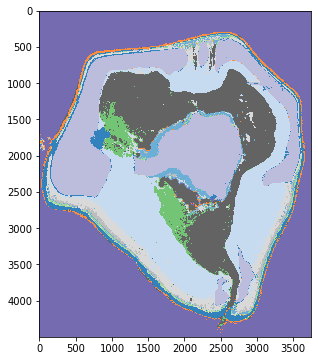

In [14]:
plt.figure(figsize=(6,6))
plt.imshow(predicted_map_pixelbased_rf_classes, interpolation='None', cmap='tab20c_r')
plt.show()

In [39]:
%%time
map_test.segmentation(use_pb_pred=True, scale=1.5, sigma=1., min_size=100)

Wall time: 58.7 s


In [40]:
%%time
map_test.smooth_pb_rf()

Wall time: 5.93 s


In [41]:
map_test.smoothed_map_pb_rf = map_test.smoothed_map_pb_rf+1
smooth_map = map_test.smoothed_map_pb_rf

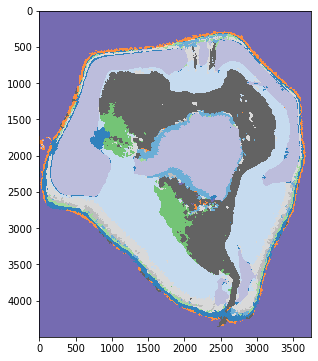

In [42]:
plt.figure(figsize=(6,6))
plt.imshow(smooth_map, interpolation='None', cmap='tab20c_r')
plt.show()

In [32]:
np.save('data/smooth_map_2m.npy', smooth_map)

In [43]:
score_map_smooth = score_map(img_rugo_zones, smooth_map,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=11)
print(score_map_smooth)

0.8953790916521523


# Post processing

In [ ]:
predicted_map_pixelbased_rf_classes = np.load('data/prediction_pb_2m.npy')
smooth_map = np.load('data/smooth_map_2m.npy')

In [9]:
import segments_regressor
from skimage.segmentation import find_boundaries

In [45]:
segments_classes = np.copy(map_test.y_segments_pb_rf_classes)
segments_classes

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [46]:
boundaries = find_boundaries(map_test.segments)
adjacent_segments,_ = segments_regressor.find_adjacent_segments(map_test.segments, boundaries)

In [47]:
%%time
list_wrong_neighbours = []
for i in range(len(adjacent_segments)):
    wrong_neighbours = 0
    s = adjacent_segments[i]
    s_class = segments_classes[i]
    if s_class > 0:
        s_connectivity = connectivity[s_class]
        for j in s:
            if segments_classes[j]>0:
                if s_connectivity[segments_classes[j]] == 0 :
                    wrong_neighbours += 1
    list_wrong_neighbours.append(wrong_neighbours/len(s))

Wall time: 638 ms


In [48]:
threshold = 0.8
nb_wrong_segments=0
for i, value in enumerate(list_wrong_neighbours):
    if value>0:
        #assign the majority of neighbours to this segment
        nb_wrong_segments+=1
        lst_temp = [segments_classes[j] for j in adjacent_segments[i]]
        majority_neighbours = max(set(lst_temp), key=lst_temp.count)
        if majority_neighbours/len(lst_temp) > threshold:
            segments_classes[i] = majority_neighbours
print(nb_wrong_segments)

1522


In [49]:
new_map = np.copy(map_test.segments)
for i in range(np.max(map_test.segments)+1):
    new_map[map_test.segments==i] = segments_classes[i]+1

In [53]:
score_pp = score_map(img_rugo_zones,new_map,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=11)
score_pp

0.896259580532102

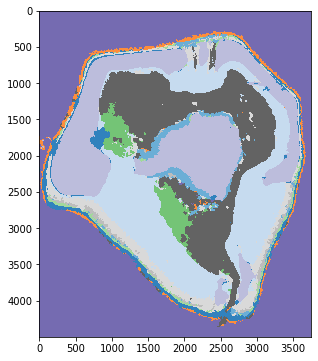

In [51]:
plt.figure(figsize=(6,6))
plt.imshow(new_map, interpolation='None', cmap='tab20c_r')
plt.show()

# Summary of the performances

In [54]:
print('Score of the pixel-based map:', np.round(score_pb, 4))
print('Score of the smoothed map:', np.round(score_map_smooth,4))
print('Score of the post-processed map:', np.round(score_pp,4))

Score of the pixel-based map: 0.9056
Score of the smoothed map: 0.8954
Score of the post-processed map: 0.8963


# Repeat 10 times

In [10]:
%%time
scores_pb = [0.9056]
scores_smooth = [0.8954]
scores_pp = [0.8963]
for i in range(1,10):
    map_test = coral_map([img_blue,img_green,img_red,img_nir], map_img=img_rugo_zones, size_img=11)
    random.seed(i)
    
    random_train_test = random.sample(index_combination,size_subset)
    training_set_indexes_pb = random_train_test[:size_subset//5]
    testing_set_indexes_pb = random_train_test[size_subset//5:]

    map_test.train_pixelbased_rf(training_set_indexes_pb, testing_set_indexes_pb, undersampling=0)

    map_test.predict_map_pixelbased_rf()

    predicted_map_pixelbased_rf_classes = np.argmax(map_test.predicted_map_pb_rf,axis=2)+1
    score_pb = score_map(img_rugo_zones,predicted_map_pixelbased_rf_classes,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=11)
    
    #smoothing
    map_test.segmentation(use_pb_pred=True, scale=1.5, sigma=1., min_size=100)
    map_test.smooth_pb_rf()
    map_test.smoothed_map_pb_rf = map_test.smoothed_map_pb_rf+1
    smooth_map = np.copy(map_test.smoothed_map_pb_rf)
    score_map_smooth = score_map(img_rugo_zones, smooth_map,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=11)
    
    #post-processing
    segments_classes = np.copy(map_test.y_segments_pb_rf_classes)
    boundaries = find_boundaries(map_test.segments)
    adjacent_segments,_ = segments_regressor.find_adjacent_segments(map_test.segments, boundaries)

    list_wrong_neighbours = []
    for i in range(len(adjacent_segments)):
        wrong_neighbours = 0
        s = adjacent_segments[i]
        s_class = segments_classes[i]
        if s_class > 0:
            s_connectivity = connectivity[s_class]
            for j in s:
                if segments_classes[j]>0:
                    if s_connectivity[segments_classes[j]] == 0 :
                        wrong_neighbours += 1
        list_wrong_neighbours.append(wrong_neighbours/len(s))

    threshold = 0.8
    nb_wrong_segments=0
    for i, value in enumerate(list_wrong_neighbours):
        if value>0:
            #assign the majority of neighbours to this segment
            nb_wrong_segments+=1
            lst_temp = [segments_classes[j] for j in adjacent_segments[i]]
            majority_neighbours = max(set(lst_temp), key=lst_temp.count)
            if majority_neighbours/len(lst_temp) > threshold:
                segments_classes[i] = majority_neighbours

    new_map = np.copy(map_test.segments)
    for i in range(np.max(map_test.segments)+1):
        new_map[map_test.segments==i] = segments_classes[i]+1

    score_pp = score_map(img_rugo_zones,new_map,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=11)
    
    scores_pb.append(score_pb)
    scores_smooth.append(score_map_smooth)
    scores_pp.append(score_pp)
    
    print(scores_pb)
    print(scores_smooth)
    print(scores_pp)

C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.958975


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)


[0.9056, 0.9000107106517432]
[0.8954, 0.8887773791035184]
[0.8963, 0.8885545975472607]


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.95819


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)


[0.9056, 0.9000107106517432, 0.8993058806941409]
[0.8954, 0.8887773791035184, 0.8876945315367386]
[0.8963, 0.8885545975472607, 0.8901151770924485]


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.95927


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)


[0.9056, 0.9000107106517432, 0.8993058806941409, 0.9006777525960777]
[0.8954, 0.8887773791035184, 0.8876945315367386, 0.8872335958570421]
[0.8963, 0.8885545975472607, 0.8901151770924485, 0.8871000909771157]


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.959


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)


[0.9056, 0.9000107106517432, 0.8993058806941409, 0.9006777525960777, 0.8993409935082318]
[0.8954, 0.8887773791035184, 0.8876945315367386, 0.8872335958570421, 0.8842775398206398]
[0.8963, 0.8885545975472607, 0.8901151770924485, 0.8871000909771157, 0.8862361547985544]


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.958515


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)


[0.9056, 0.9000107106517432, 0.8993058806941409, 0.9006777525960777, 0.8993409935082318, 0.8980960609395695]
[0.8954, 0.8887773791035184, 0.8876945315367386, 0.8872335958570421, 0.8842775398206398, 0.8857108454604795]
[0.8963, 0.8885545975472607, 0.8901151770924485, 0.8871000909771157, 0.8862361547985544, 0.8896684953325714]


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.959655


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)


[0.9056, 0.9000107106517432, 0.8993058806941409, 0.9006777525960777, 0.8993409935082318, 0.8980960609395695, 0.906060827304673]
[0.8954, 0.8887773791035184, 0.8876945315367386, 0.8872335958570421, 0.8842775398206398, 0.8857108454604795, 0.8942638050766664]
[0.8963, 0.8885545975472607, 0.8901151770924485, 0.8871000909771157, 0.8862361547985544, 0.8896684953325714, 0.8942987231620125]


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.95886


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)


[0.9056, 0.9000107106517432, 0.8993058806941409, 0.9006777525960777, 0.8993409935082318, 0.8980960609395695, 0.906060827304673, 0.8998920999116206]
[0.8954, 0.8887773791035184, 0.8876945315367386, 0.8872335958570421, 0.8842775398206398, 0.8857108454604795, 0.8942638050766664, 0.8851003492273238]
[0.8963, 0.8885545975472607, 0.8901151770924485, 0.8871000909771157, 0.8862361547985544, 0.8896684953325714, 0.8942987231620125, 0.8857031310331809]


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.95824


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)


[0.9056, 0.9000107106517432, 0.8993058806941409, 0.9006777525960777, 0.8993409935082318, 0.8980960609395695, 0.906060827304673, 0.8998920999116206, 0.8974010318415361]
[0.8954, 0.8887773791035184, 0.8876945315367386, 0.8872335958570421, 0.8842775398206398, 0.8857108454604795, 0.8942638050766664, 0.8851003492273238, 0.8868336466735399]
[0.8963, 0.8885545975472607, 0.8901151770924485, 0.8871000909771157, 0.8862361547985544, 0.8896684953325714, 0.8942987231620125, 0.8857031310331809, 0.8874858624516291]


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:142: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.95861


C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:92: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_for_segmentation,*args,**kwargs)


[0.9056, 0.9000107106517432, 0.8993058806941409, 0.9006777525960777, 0.8993409935082318, 0.8980960609395695, 0.906060827304673, 0.8998920999116206, 0.8974010318415361, 0.8969416431045812]
[0.8954, 0.8887773791035184, 0.8876945315367386, 0.8872335958570421, 0.8842775398206398, 0.8857108454604795, 0.8942638050766664, 0.8851003492273238, 0.8868336466735399, 0.8844982808371146]
[0.8963, 0.8885545975472607, 0.8901151770924485, 0.8871000909771157, 0.8862361547985544, 0.8896684953325714, 0.8942987231620125, 0.8857031310331809, 0.8874858624516291, 0.8850790427752677]
Wall time: 5h 43min 53s


In [11]:
print(np.round(np.mean(scores_pb),4), np.round(np.std(scores_pb),4))
print(np.round(np.mean(scores_smooth),4), np.round(np.std(scores_smooth),4))
print(np.round(np.mean(scores_pp),4), np.round(np.std(scores_pp),4))

0.9003 0.003
0.888 0.0037
0.8891 0.0035
